In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd
import dask

from ast import literal_eval
from collections import Counter
from collections.abc import MutableMapping
import dask.array as da
from functools import reduce
# import h5py
import os

In [9]:
# from geopy.geocoders import Nominatim
import reverse_geocode

In [4]:
Client()

# Load the dataset

## Slowload of json

In [6]:
# b = db.read_text("data/users.clean.json", blocksize="128MiB")
# type(b)

dask.bag.core.Bag

### Schema of users dataset

In [6]:
meta={'userName': str,
      'jobs': object,
      'currentPlace': object,
      'previousPlaces': object,
      'education': object,
      'gPlusUserId': str}

### Run only once - split into smaller files

In [8]:
%%time
# b.map(literal_eval).to_dataframe(meta=meta).to_csv('users/*.csv', index=False) # ? minutes

CPU times: user 8.53 s, sys: 1.06 s, total: 9.59 s
Wall time: 2min 28s


['/home/wardhuang/github/anylee2142/cmpe256-team4/users/0.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/1.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/2.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/3.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/4.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/5.csv',
 '/home/wardhuang/github/anylee2142/cmpe256-team4/users/6.csv']

### Fastload of smaller files

In [43]:
%%time
# read smaller files
# 10 s
df = dd.read_csv('users/*.csv',
                 blocksize='128MiB',
                 dtype=meta,
                 encoding='utf-8',
                 lineterminator='\n').compute()

CPU times: user 3.21 s, sys: 1.39 s, total: 4.6 s
Wall time: 10.9 s


## Preliminary analysis

In [44]:
df.count()

userName          3747937
jobs               681969
currentPlace       749941
previousPlaces     412421
education         3734551
gPlusUserId       3747937
dtype: int64

# Current Place

The current places are stored in an array.

Extract the coordinates and filter out users with "custom locations"

In [55]:
%%time

curr_place = df['currentPlace'].dropna()

# eval string to array
curr_place = curr_place.map(eval)

# custom current location
customLoc = []

# # check format of custom locations
# lengths = Counter()

# select just the gps coordinates
def select_gps(arr):
    try:
        return arr[1][1:3]
    except Exception as e:
        customLoc.append(arr[0])
        # lengths[len(arr)] += 1
        return None
curr_place = curr_place.map(select_gps).dropna()

# # check format of custom locations
# print(lengths)

print(f'Number of users with custom locations: {len(customLoc)}\n')

# lol
# print(customLoc)

del customLoc
# del curr_place

Number of users with custom locations: 12302

CPU times: user 10.2 s, sys: 211 ms, total: 10.4 s
Wall time: 10.4 s


### Current places (by country) 

The users dataset has **all** coordinates stored as a multiple of 10 mil

*The places dataset has some coordinates stored as a multiple of 1 mil*

In [59]:
%%time

# scale the weird gps coords to normal ones
def scale_coords(coord):
    if abs(coord[0]) > 90 or abs(coord[1]) > 180:
        # Users - Divide by 10,000,000...
        # Places - Divide by 1,000,000...
        return (coord[0]/10000000, coord[1]/10000000)
    return coord

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 40.5 µs


Num of weird gps coords: 737639

Num of unique countries: 243

('United States', 340400)
('India', 52230)
('United Kingdom', 30856)
('Canada', 24440)
('Brazil', 22614)
('Germany', 19116)
('Spain', 17503)
('Italy', 14919)
('France', 14276)
('Australia', 11512) 

CPU times: user 2.54 s, sys: 7.63 ms, total: 2.55 s
Wall time: 2.51 s


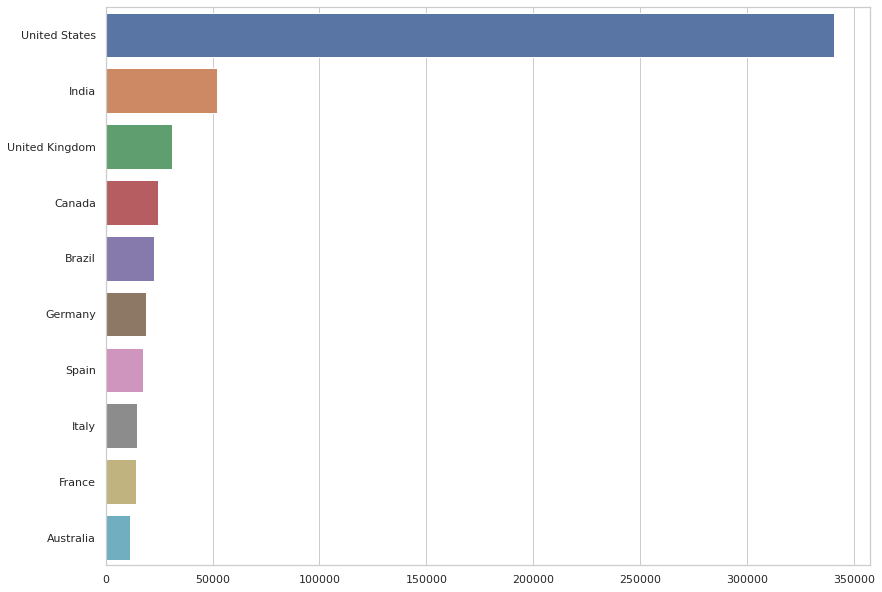

In [69]:
%%time

# weird gps coords
numWeirdCoord = 0
for coord in curr_place:
    if abs(coord[0]) > 90 or abs(coord[1]) > 180:
        numWeirdCoord += 1
print(f'Num of weird gps coords: {numWeirdCoord}\n')

# scale weird coords to standard lat, long
listOfCoords = curr_place.map(scale_coords).to_list()
listOfCities = reverse_geocode.search(listOfCoords)

# count by country
countryCount = Counter([cityState['country'] for cityState in listOfCities])

# num of unique countries
print(f'Num of unique countries: {len(countryCount)}\n')

# top 10 countries with users registered on google
topCountries = countryCount.most_common(10)
print('\n'.join([str(t) for t in topCountries]),'\n')

y_axis = [country for country, _ in topCountries]
x_axis = [places for _, places in topCountries]
sns.barplot(y=y_axis, x=x_axis)

del x_axis, y_axis, topCountries, countryCount, numWeirdCoord
# del listOfCoords, listOfCities

## Scatterplot of users ( with current location )

Compare with the scatterplot of places dataset

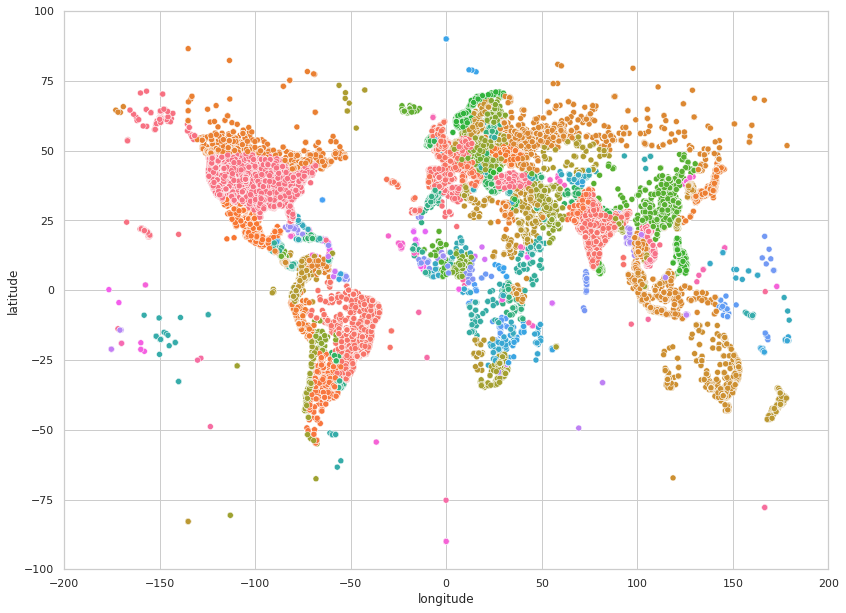

In [71]:
%%time
ax = plt.subplot(xscale='linear',
                yscale='linear',
                xlim=(-200, 200),
                ylim=(-100, 100))
lat, long = zip(*listOfCoords)
countries = [c['country'] for c in listOfCities]
placeDF = pd.DataFrame({'latitude': lat, 'longitude': long, 'country': countries})
sns.scatterplot(data=placeDF,
                x='longitude',
                y='latitude',
                hue='country',
                legend=False,
                ax=ax)
del placeDF, countries, lat, long, ax